In [224]:
#Useful packages to solve the problems
import numpy as np
import scipy as sp
from scipy import optimize
from scipy import interpolate
import sympy as sm
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



sm.init_printing(use_unicode=True)


# 1. Human capital accumulation

Consider a worker living in **two periods**, $t \in \{1,2\}$. 

In each period she decides whether to **work ($l_t = 1$) or not ($l_t = 0$)**. 

She can *not* borrow or save and thus **consumes all of her income** in each period. 

If she **works** her **consumption** becomes:

$$c_t = w h_t l_t\,\,\text{if}\,\,l_t=1$$

where $w$ is **the wage rate** and $h_t$ is her **human capital**. 

If she does **not work** her consumption becomes:

$$c_t = b\,\,\text{if}\,\,l_t=0$$

where $b$ is the **unemployment benefits**.

Her **utility of consumption** is: 

$$ \frac{c_t^{1-\rho}}{1-\rho} $$

Her **disutility of working** is:

$$ \gamma l_t $$

From period 1 to period 2, she **accumulates human capital** according to:

$$ h_2 = h_1 + l_1 + 
\begin{cases}
0 & \text{with prob. }0.5 \\
\Delta & \text{with prob. }0.5 
\end{cases} \\
$$

where $\Delta$ is a **stochastic experience gain**.

In the **second period** the worker thus solves:

$$
\begin{eqnarray*}
v_{2}(h_{2}) & = &\max_{l_{2}} \frac{c_2^{1-\rho}}{1-\rho} - \gamma l_2
\\ & \text{s.t.} & \\
c_{2}& = & \begin{cases}
w h_2 & 
\text{if }l_2 = 1  \\
b & \text{if }l_2 = 0 
\end{cases} \\
l_{2}& \in &\{0,1\}
\end{eqnarray*}
$$

In the **first period** the worker thus solves:

$$
\begin{eqnarray*}
v_{1}(h_{1}) &=& \max_{l_{1}} \frac{c_1^{1-\rho}}{1-\rho} - \gamma l_1 + \beta\mathbb{E}_{1}\left[v_2(h_2)\right]
\\ & \text{s.t.} & \\
c_{1}& = & \begin{cases}
w h_1 & 
\text{if }l_1 = 1  \\
b & \text{if }l_1 = 0 
\end{cases} \\
h_2 &=& h_1 + l_1 + \begin{cases}
0 & \text{with prob. }0.5\\
\Delta & \text{with prob. }0.5 
\end{cases}\\
l_{1} &\in& \{0,1\}\\
\end{eqnarray*}
$$

where $\beta$ is the **discount factor** and $\mathbb{E}_{1}\left[v_2(h_2)\right]$ is the **expected value of living in period two**.

The **parameters** of the model are:

In [225]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1

The **relevant levels of human capital** are:

In [226]:
h_vec = np.linspace(0.1,1.5,100) 

**Question 1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital). 


To solve the model we define the functions for utility, disutility and consumption.

In [227]:
# Binaries for employment
l_emp = 1
l_unemp = 0

# Defining functions
def utility(c,rho):
    return c**(1-rho)/(1-rho)

def disutility(gamma,l):
    return gamma*l

def consumption(w,h,b,l):
    if l == 1:
        return w*h*l
    else:
        return b
    
def v2(l2, w, b, h2, rho, gamma):
    return utility(consumption(w,h2,b,l2),rho)-disutility(gamma,l2)

def v1(l1,w,b,rho,gamma,h1,Delta,beta,exp_v2):
    
    # a. human capital accumulation if she does not work in period 1
    h2_unemp = h1 + l1
    v2_unemp = exp_v2([h2_unemp])[0]
    
    # b. human capital accumulation if she do work in period 1
    h2_emp = h1 + l1 + Delta
    v2_emp = exp_v2([h2_emp])[0]
    
    # c. Expected value of v2
    v2 = 0.5*v2_unemp + 0.5*v2_emp
    
    # d. value of utility
    return utility(consumption(w,h1,b,l1),rho)-disutility(gamma,l1) + beta*v2

Using the defined functions we can now solve model including labor supply as a function of human capital and illustrate for period 2.

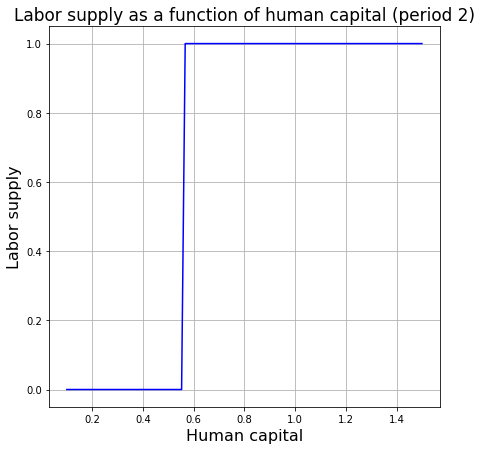

In [228]:
#Solving period 2
def solve_hum2(rho,w,b,h_vec,gamma,Delta):

    # a. defining the grids
    v2_vec = np.empty(100)
    l2_vec = np.empty(100)

    # b. solve for each level of human capital in the grids
    for i,h in enumerate(h_vec):
       
        # i. test if it maximizes v2 to be employed or unemployed
        if (v2(l_unemp,w,b,h,rho,gamma) > v2(l_emp,w,b,h,rho,gamma)):
            l2_vec[i] = 0
        else:
            l2_vec[i] = 1
        
        # ii. appending the optimal values of l2 from i. on v2 
        v2_vec[i] = v2(l2_vec[i],w,b,h,rho,gamma)
               
    return v2_vec, l2_vec

v2_vec, l2_vec = solve_hum2(rho,w,b,h_vec,gamma,Delta)

# illustrating the solution
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)
ax.plot(h_vec, l2_vec, 'b-')
#labels
ax.set_title('Labor supply as a function of human capital (period 2)', fontsize=17)
ax.set_ylabel('Labor supply', fontsize=16)
ax.set_xlabel('Human capital',fontsize=16)
ax.grid()


In [229]:
index = np.where(l2_vec == 1)[0][0];
print('Result: Works in period 2 if the level of human capital ≥ '+str(round(h_vec[index],4)))

Result: Works in period 2 if the level of human capital ≥ 0.5667


**Question 2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital). 

We solve the model first by interpolating and then illustrate the result for period 1.

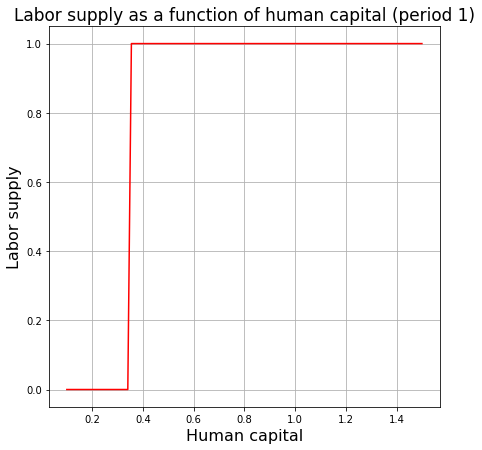

In [230]:
# interpolate
exp_v2 = interpolate.RegularGridInterpolator((h_vec,),v2_vec,bounds_error=False,fill_value=None)

def solve_hum1(w,b,rho,gamma,h_vec,Delta,beta,exp_v2):
    
    # a. Grids
    v1_vec = np.empty(100)
    l1_vec = np.empty(100)
    c1_vec = np.empty(100)
    
    # b. Solve for each h in grid
    for i,h in enumerate(h_vec):
       
        # 1. Test if it maximizes v2 to be employed or unemployed
        if (v1(l_unemp,w,b,rho,gamma,h,Delta,beta,exp_v2) > v1(l_emp,w,b,rho,gamma,h,Delta,beta,exp_v2)):
            l1_vec[i] = 0
        else:
            l1_vec[i] = 1
        
        # 2. Appending the optimal values of l2 from 1. on v2 
        v1_vec[i] = v1(l1_vec[i], w, b, rho, gamma, h, Delta, beta, exp_v2)
        c1_vec[i] = consumption(w,h,b,l1_vec[i])
               
    return v1_vec, l1_vec, c1_vec

v1_vec, l1_vec, c1_vec  = solve_hum1(w,b,rho,gamma,h_vec,Delta,beta,exp_v2)

# illustrating the solution
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)
ax.plot(h_vec, l1_vec, "r-")
#labels
ax.set_title('Labor supply as a function of human capital (period 1)', fontsize=17)
ax.set_ylabel('Labor supply', fontsize=16)
ax.set_xlabel('Human capital',fontsize=16)
ax.grid()
    

In [231]:
index = np.where(l1_vec == 1)[0][0];
print('Result: Works in period 1 if the level of human capital ≥ '+str(round(h_vec[index],4)))

Result: Works in period 1 if the level of human capital ≥ 0.3545


**Question 3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

Text(0, 0.5, 'Consumption')

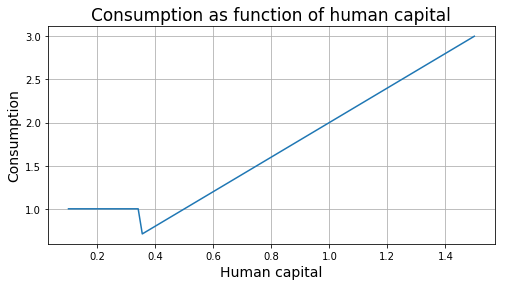

In [232]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.plot(h_vec,c1_vec)
ax.grid()
plt.title('Consumption as function of human capital', fontsize=17)
ax.set_xlabel('Human capital', fontsize=14)
ax.set_ylabel('Consumption', fontsize=14)

We can see as the human capital accumulation grows, the amount of consumption rises, there is a small dent at the level of 0.355, which is the point of where she would choose to work in period 1, but which also gives an indication that she would work if her potential wage income is lower than the unemployment benefits. We also see that as the human capital grows her consumption rises to a higher level than the benefits she would get from being unemployed. This would reason that she would choose to work, as she has more to gain by working, or in other words, her opportunity cost is higher by not working than working.

# 2. AS-AD model

Consider the following **AS-AD model**. The **goods market equilibrium** is given by

$$ y_{t} = -\alpha r_{t} + v_{t} $$

where $y_{t}$ is the **output gap**, $r_{t}$ is the **ex ante real interest** and $v_{t}$ is a **demand disturbance**. 

The central bank's **Taylor rule** is

$$ i_{t} = \pi_{t+1}^{e} + h \pi_{t} + b y_{t}$$

where $i_{t}$ is the **nominal interest rate**, $\pi_{t}$ is the **inflation gap**, and $\pi_{t+1}^{e}$ is the **expected inflation gap**. 

The **ex ante real interest rate** is given by 

$$ r_{t} = i_{t} - \pi_{t+1}^{e} $$

Together, the above implies that the **AD-curve** is

$$ \pi_{t} = \frac{1}{h\alpha}\left[v_{t} - (1+b\alpha)y_{t}\right]$$

Further, assume that the **short-run supply curve (SRAS)** is given by

$$ \pi_{t} = \pi_{t}^{e} + \gamma y_{t} + s_{t}$$

where $s_t$ is a **supply disturbance**.

**Inflation expectations are adaptive** and given by

$$ \pi_{t}^{e} = \phi\pi_{t-1}^{e} + (1-\phi)\pi_{t-1}$$

Together, this implies that the **SRAS-curve** can also be written as

$$ \pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1} $$

The **parameters** of the model are:

In [233]:
par = {}

par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075

**Question 1:** Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$.


The **variables** and **parameters** of the model are:

In [234]:
y_t = sm.symbols('y_t')
y_lag = sm.symbols('y_t-1')
r_t = sm.symbols('r_t')
v_t = sm.symbols('v_t')
pi_t = sm.symbols('pi_t')
pi_t_e = sm.symbols('pi_t^e')
pi_plu_e = sm.symbols('pi_t+1^e')
pi_lag = sm.symbols('pi_t-1')
s_t = sm.symbols('s_t')
s_lag = sm.symbols('s_t-1')
i_t = sm.symbols('i_t')

h = sm.symbols('h')
b = sm.symbols('b')
alpha = sm.symbols('alpha')
phi = sm.symbols('phi')
gamma = sm.symbols('gamma')

Defining the AD-curve:

In [235]:
AD = sm.Eq(pi_t, 1/(h*alpha)*(v_t-(1+b*alpha)*y_t))
AD

Defining the SRAS-curve:

In [236]:
SRAS = sm.Eq(pi_t, pi_lag+gamma*y_t-phi*gamma*y_lag +s_t-phi*s_lag)
SRAS

Solving to find the equilibrium of the output and inflation gap:

Result: The equilibrium of the output and inflation gap


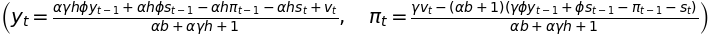

In [237]:
equi = sm.solve([AD,SRAS], [y_t, pi_t])
y_equi = equi[y_t]
pi_equi = equi[pi_t]

print('Result: The equilibrium of the output and inflation gap')
sm.Eq(y_t,y_equi), sm.Eq(pi_t,pi_equi)

**Question 2:** Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.

In [238]:
# Giving new values to the variables
var = {}

var['y_lag'] = 0
var['pi_lag'] = 0
var['s_lag'] = 0
var['s_t'] = 0
var['v_t'] = 0
var['v_t_shock'] = 0.1

The equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$:

In [239]:
#Finding the equilibrium for output
y_v = sm.lambdify((alpha,h,b,phi,gamma,y_lag,pi_lag,s_lag,s_t,v_t),y_equi)
y_p = y_v(par['alpha'],par['h'],par['b'],par['phi'],par['gamma'],var['y_lag'],var['pi_lag'],var['s_lag'],var['s_t'],var['v_t'])
print(f'The equilibrium for y: {y_p}')

#Finding the equilibrium for inflation
pi_v = sm.lambdify((alpha,h,b,phi,gamma,y_lag,pi_lag,s_lag,s_t,v_t),pi_equi)
pi_p = pi_v(par['alpha'],par['h'],par['b'],par['phi'],par['gamma'],var['y_lag'],var['pi_lag'],var['s_lag'],var['s_t'],var['v_t'])
print(f'The equilibrium for pi: {pi_p}')

The equilibrium for y: 0.0
The equilibrium for pi: 0.0


Now, we look at how the equilibrium changes, when there is a shock to $v_t$:

In [240]:
#Finding the equilibrium for output (with change in v_t)
y_shock = sm.lambdify((h,b,alpha,gamma,phi,y_lag,pi_lag,s_lag,s_t,v_t),y_equi)
y_p_shock = y_shock(par['h'],par['b'],par['alpha'],par['gamma'],par['phi'],var['y_lag'],var['pi_lag'],var['s_lag'],var['s_t'],var['v_t_shock'])
print(f'The new equilibrium for y after the shock: {round(y_p_shock,4)}')

#Finding the equilibrium for inflation (with change in v_t)
pi_shock = sm.lambdify((h,b,alpha,gamma,phi,y_lag,pi_lag,s_lag,s_t,v_t),pi_equi)
pi_p_shock = pi_shock(par['h'],par['b'],par['alpha'],par['gamma'],par['phi'],var['y_lag'],var['pi_lag'],var['s_lag'],var['s_t'],var['v_t_shock'])
print(f'The new equilibrium for pi after the shock: {round(pi_p_shock,4)}')


The new equilibrium for y after the shock: 0.0244
The new equilibrium for pi after the shock: 0.0018


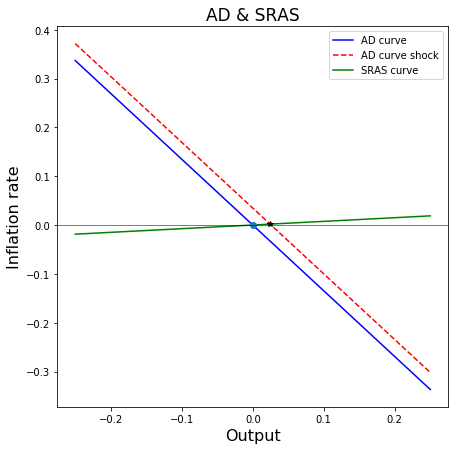

In [241]:
#Plotting the new equilibria
def AD_func(y_t,h,b,alpha,v_t):
    return (1/(h*alpha)*(v_t-(1+b*alpha)*y_t))
def SRAS_func(pi_lag,gamma,y_t,phi,y_lag,s_t,s_lag):
    return (pi_lag+gamma*y_t-phi*gamma*y_lag+s_t-phi*s_lag)

def AD_plot(v):
    y_value = np.linspace(-0.25,0.25,100)
    AD_curve = AD_func(y_value,par['h'],par['b'],par['alpha'],v)
    AD_curve_shock = AD_func(y_value,par['h'],par['b'],par['alpha'],v+0.1)
    SRAS_curve = SRAS_func(var['pi_lag'],par['gamma'],y_value,par['phi'],var['y_lag'],var['s_t'],var['s_lag'])
    plt.figure(figsize=(7,7))
    plt.plot(y_value,AD_curve, 'b-')
    plt.plot(y_value,AD_curve_shock,'r--')
    plt.plot(y_value,SRAS_curve, 'g-')
    plt.plot(y_p_shock,pi_p_shock,'k*')
    plt.plot(0,0,'o')
    plt.axhline(color='k', linewidth=0.5)
    plt.title('AD & SRAS', fontsize=17)
    plt.xlabel('Output', fontsize=16)
    plt.ylabel('Inflation rate', fontsize=16)
    plt.legend(('AD curve', 'AD curve shock', 'SRAS curve'))
    
    return plt

plt.show(AD_plot(0))

As can be seen in the graph, the shock to $v_t$, moves the AD curve to the right. This creates a new and higher equilibrium. It moves from the orange dot in (0,0) to the black star in (0.0244,0.0018)

**Persistent disturbances:** Now, additionaly, assume that both the demand and the supply disturbances are AR(1) processes

$$ v_{t} = \delta v_{t-1} + x_{t} $$
$$ s_{t} = \omega s_{t-1} + c_{t} $$

where $x_{t}$ is a **demand shock**, and $c_t$ is a **supply shock**. The **autoregressive parameters** are:

In [242]:
par['delta'] = 0.80
par['omega'] = 0.15

**Question 3:** Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?

First, we define the new $s_t$ and $v_t$:

In [243]:
def v_dist(v_lag, x_t):
    return par['delta']*v_lag+x_t
def s_dist(s_lag, c_t):
    return par['omega']*s_lag+c_t

In [244]:
T = 100
y_vec = [0]
pi_vec = [0]
v_vec = [0]
s_vec = [0]
c_vec = np.zeros(T)
x_vec = np.zeros(T)
x_vec[1] = 0.1

In [245]:
for t in range(1,T):
    
    v_vec.append(v_dist(v_vec[t-1], x_vec[t]))
    s_vec.append(s_dist(s_vec[t-1], c_vec[t]))
    y_vec.append(y_v(par['alpha'],par['h'],par['b'],par['phi'],par['gamma'],y_vec[t-1],pi_vec[t-1],s_vec[t-1],s_vec[t],v_vec[t]))
    pi_vec.append(pi_v(par['alpha'],par['h'],par['b'],par['phi'],par['gamma'],y_vec[t-1],pi_vec[t-1],s_vec[t-1],s_vec[t],v_vec[t]))

Illustrating how the economy evolves over time:

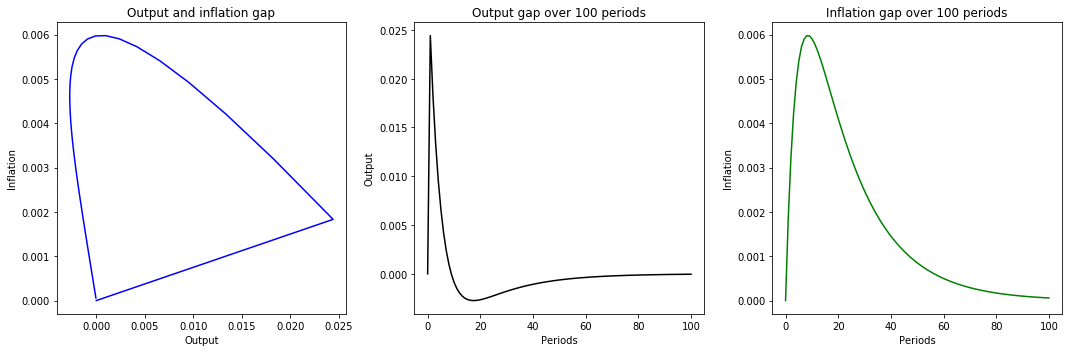

In [246]:
# Plotting the figures
periods_100 = np.linspace(0,T,T)

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.plot(y_vec,pi_vec, "b-")
ax1.set_title('Output and inflation gap')
ax1.set_xlabel('Output')
ax1.set_ylabel('Inflation')

ax2.plot(periods_100,y_vec,"k-")
ax2.set_title('Output gap over 100 periods')
ax2.set_xlabel('Periods')
ax2.set_ylabel('Output')

ax3.plot(periods_100,pi_vec, "g-")
ax3.set_title('Inflation gap over 100 periods')
ax3.set_xlabel('Periods')
ax3.set_ylabel('Inflation')


plt.tight_layout()

In all the graphs we experience a change in $x_0$ in period 0. In the graph representing the "output and inflation gap" the demand shock causes a spike, but the inflation returns to the equilibrium. The graph which represents the development in the "output gap over 100 periods" and the development in the "inflation gap over 100 periods" experience a shock which causes the spike, but the one on the left converges faster to equilibrium than the one on the right. 

**Stochastic shocks:** Now, additionally, assume that $x_t$ and $c_t$ are stochastic and normally distributed

$$ x_{t}\sim\mathcal{N}(0,\sigma_{x}^{2}) $$
$$ c_{t}\sim\mathcal{N}(0,\sigma_{c}^{2}) $$

The **standard deviations of the shocks** are:

In [247]:
par['sigma_x'] = 3.492
par['sigma_c'] = 0.2

**Question 4:** Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

In [250]:
np.random.seed(1234)

T = 1000
y_vec_new = [0]
pi_vec_new = [0]
v_vec_new = [0]
s_vec_new = [0]
x_vec_new = np.zeros(T)
c_vec_new = np.zeros(T)
c_vec_t = np.random.normal(0,par['sigma_c'],T)
x_vec_t = np.random.normal(0,par['sigma_x'],T)


for t in range(1,T):
    
    v_vec_new.append(v_dist(v_vec_new[t-1], x_vec_t[t]))
    s_vec_new.append(s_dist(s_vec_new[t-1], c_vec_t[t]))
    y_vec_new.append(y_v(par['alpha'],par['h'],par['b'],par['phi'],par['gamma'],y_vec_new[t-1],pi_vec_new[t-1],s_vec_new[t-1],s_vec_new[t],v_vec_new[t]))
    pi_vec_new.append(pi_v(par['alpha'],par['h'],par['b'],par['phi'],par['gamma'],y_vec_new[t-1],pi_vec_new[t-1],s_vec_new[t-1],s_vec_new[t],v_vec_new[t]))

In [251]:
y_var = np.var(y_vec_new)
pi_var = np.var(pi_vec_new)
corr_y_pi = np.corrcoef(y_vec_new,pi_vec_new)
y_ac = np.corrcoef(y_vec_new[1:],y_vec_new[:-1])
pi_ac = np.corrcoef(pi_vec_new[1:],pi_vec_new[:-1])

print(f'Variance of y_t: {y_var:.4f}')
print(f'Variance of pi_t: {pi_var:.4f}')
print(f'Correlation between y_t and pi_t: {corr_y_pi[0,1]:.4f}')
print(f'Auto-correlation between y_t and y_t-1: {y_ac[0,1]:.4f}')
print(f'Auto-correlation between pi_t and pi_t-1: {pi_ac[0,1]:.4f}')

Variance of y_t: 2.0023
Variance of pi_t: 1.0483
Correlation between y_t and pi_t: -0.2350
Auto-correlation between y_t and y_t-1: 0.7863
Auto-correlation between pi_t and pi_t-1: 0.9785


**Question 5:** Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

We simulate by appending on empty vector via a for loop and plot how the correlation between $y_t$ and changes with $\phi$

In [252]:
# Simulation of AS-AD Model with change in phi
np.random.seed(1234)

T = 1000
x_vec_031 = np.random.normal(0,par['sigma_x'],T)
c_vec_031 = np.random.normal(0,par['sigma_c'],T)

def simulation_031(phi):
    y_vec_031 = [0]
    pi_vec_031 = [0]
    v_vec_031 = [0]
    s_vec_031 = [0]
    corr_y_pi_031 = [0]
    for t in range(1,T):
        v_vec_031.append(v_dist(v_vec_031[t-1], x_vec_031[t]))
        s_vec_031.append(s_dist(s_vec_031[t-1], c_vec_031[t]))
        y_vec_031.append(y_v(par['alpha'],par['h'],par['b'],phi,par['gamma'],y_vec_031[t-1],pi_vec_031[t-1],s_vec_031[t-1],s_vec_031[t],v_vec_031[t]))
        pi_vec_031.append(pi_v(par['alpha'],par['h'],par['b'],phi,par['gamma'],y_vec_031[t-1],pi_vec_031[t-1],s_vec_031[t-1],s_vec_031[t],v_vec_031[t]))
   
            
    corr_y_pi_031 = np.corrcoef(y_vec_031, pi_vec_031)[1,0]
    
    return y_vec_031, pi_vec_031, corr_y_pi_031

y_vec_031, pi_vec_031, corr_y_pi_031 = simulation_031(par['phi'])

phi_plot = np.linspace(0,1,T)
corr_plot = []

for x in phi_plot:
    y_vec_031, pi_vec_031, corr_y_pi_031 = simulation_031(x)
    corr_plot.append(corr_y_pi_031)

Contstructing the plot to show the correlation of output and inflation

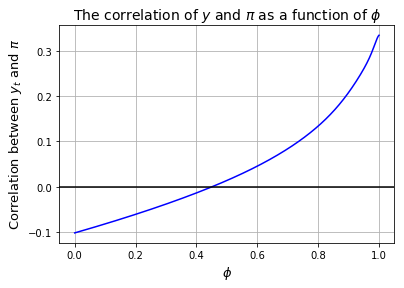

<Figure size 432x288 with 0 Axes>

In [253]:
# Plotting the figure
plt.xlabel('$\phi$', fontsize=13)
plt.ylabel('Correlation between $y_t$ and $\pi$', fontsize=13)
plt.title('The correlation of $y$ and $\pi$ as a function of $\phi$', fontsize=14)
plt.plot(phi_plot,corr_plot, "b-")
plt.axhline(color='k')
plt.grid()
plt.show()
plt.tight_layout()

We find the objective function to optimize the function to find a value for $\phi$, so the correlation between $y_t$ and $\pi$ is as close 0.31 as possible.

In [254]:
obj_phi = lambda phi: np.corrcoef(simulation_031(phi)[0], simulation_031( phi)[1])[1,0] - 0.31

result = sp.optimize.root_scalar(obj_phi, x0 = 0.9, bracket = [0,1], method = 'brentq')

phi_opt = result.root
print(f'To get a correlation on {np.corrcoef(simulation_031(phi_opt)[0], simulation_031(phi_opt)[1])[1,0]:.4f} between output and inflation, the value of phi has to be {phi_opt:.4f}')

To get a correlation on 0.3100 between output and inflation, the value of phi has to be 0.9837


**Quesiton 6:** Use a numerical optimizer to choose $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ to make the simulated statistics as close as possible to US business cycle data where:

1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

Comparing with US business cycle data

In [255]:
simstats_us = np.array([1.64, 0.21, 0.31, 0.84, 0.48])

def simulation_us(parameters_us):
    phi, sigma_x, sigma_c = parameters_us
    T = 1000
   
    np.random.seed(1234)
    
    pi_vec_us = [0]
    y_vec_us = [0]
    v_vec = [0]
    s_vec = [0]
    x = np.random.normal(0,sigma_x,T)
    c = np.random.normal(0,sigma_c,T)

    for t in range(1,T):
    
        v_vec.append(v_dist(v_vec[t-1], x[t]))
        s_vec.append(s_dist(s_vec[t-1], c[t]))
        y_vec_us.append(y_v(par['alpha'],par['h'],par['b'],phi,par['gamma'],y_vec_us[t-1],pi_vec_us[t-1],s_vec[t-1],s_vec[t],v_vec[t]))
        pi_vec_us.append(pi_v(par['alpha'],par['h'],par['b'],phi,par['gamma'],y_vec_us[t-1],pi_vec_us[t-1],s_vec[t-1],s_vec[t],v_vec[t]))
    
    pi_vec_us = np.array(pi_vec_us)
    y_vec_us = np.array(y_vec_us)

    stats_us = []
    stats_us.append(y_vec_us.var())
    stats_us.append(pi_vec_us.var())
    stats_us.append(np.corrcoef(y_vec_us, pi_vec_us)[1,0])
    stats_us.append(np.corrcoef(y_vec_us[1:], y_vec_us[:-1])[1,0])
    stats_us.append(np.corrcoef(pi_vec_us[1:], pi_vec_us[:-1])[1,0])
    
    return stats_us

In [256]:
x0_us = np.array([phi_opt,par['sigma_x'],par['sigma_c']])

parameters = [par['phi'],par['sigma_x'],par['sigma_c']]

bounds_us = [[0,1],[0,50],[0,50]]

obj_us = lambda parameters: np.sum((simulation_us(parameters) - simstats_us)**2)

# Numerical optimizer
minopt_parameters = optimize.minimize(obj_us, x0_us, bounds = bounds_us)

print(f'Sum of squares: {round(minopt_parameters.fun,4)}')

minopt_parameters = minopt_parameters.x

# Using our optimal values
sim_opt = simulation_us(minopt_parameters)

print(f'Variance of y_t: {round(sim_opt[0],2)}')
print(f'Variance of pi_t: {round(sim_opt[1],2)}')
print(f'Correlation of y_t and pi_t: {round(sim_opt[2],2)}')
print(f'Autocorrelation of y_t: {round(sim_opt[3],2)}')
print(f'Autocorrelation of pi_t: {round(sim_opt[4],2)}')

Sum of squares: 0.0298
Variance of y_t: 1.65
Variance of pi_t: 0.05
Correlation of y_t and pi_t: 0.28
Autocorrelation of y_t: 0.77
Autocorrelation of pi_t: 0.49


# 3. Exchange economy

Consider an **exchange economy** with

1. 3 goods, $(x_1,x_2,x_3)$
2. $N$ consumers indexed by \\( j \in \{1,2,\dots,N\} \\)
3. Preferences are Cobb-Douglas with log-normally distributed coefficients

    $$ \begin{eqnarray*}
    u^{j}(x_{1},x_{2},x_{3}) &=& 
    \left(x_{1}^{\beta_{1}^{j}}x_{2}^{\beta_{2}^{j}}x_{3}^{\beta_{3}^{j}}\right)^{\gamma}\\
     &  & \,\,\,\beta_{i}^{j}=\frac{\alpha_{i}^{j}}{\alpha_{1}^{j}+\alpha_{2}^{j}+\alpha_{3}^{j}} \\
     &  & \,\,\,\boldsymbol{\alpha}^{j}=(\alpha_{1}^{j},\alpha_{2}^{j},\alpha_{3}^{j}) \\ 
     &  & \,\,\,\log(\boldsymbol{\alpha}^j) \sim \mathcal{N}(\mu,\Sigma) \\
    \end{eqnarray*} $$

4. Endowments are exponentially distributed,

$$
\begin{eqnarray*}
\boldsymbol{e}^{j} &=& (e_{1}^{j},e_{2}^{j},e_{3}^{j}) \\
 &  & e_i^j \sim f, f(z;\zeta) =  1/\zeta \exp(-z/\zeta)
\end{eqnarray*}
$$

Let $p_3 = 1$ be the **numeraire**. The implied **demand functions** are:

$$
\begin{eqnarray*}
x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j})&=&\beta^{j}_i\frac{I^j}{p_{i}} \\
\end{eqnarray*}
$$

where consumer $j$'s income is

$$I^j = p_1 e_1^j + p_2 e_2^j +p_3 e_3^j$$

The **parameters** and **random preferences and endowments** are given by:

In [257]:
# a. parameters
N = 50000
mu = np.array([3,2,1])
Sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])
gamma = 0.8
zeta = 1

# b. random draws
seed = 1986
np.random.seed(seed)

# preferences
alphas = np.exp(np.random.multivariate_normal(mu, Sigma, size=N))
betas = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# endowments
e1 = np.random.exponential(zeta,size=N)
e2 = np.random.exponential(zeta,size=N)
e3 = np.random.exponential(zeta,size=N)

**Question 1:** Plot the histograms of the budget shares for each good across agents.

Because the utility function is a Cobb-Douglas, the $\beta$'s represent the budget shares.

In [258]:
beta_1 = betas[:,0]
beta_2 = betas[:,1]
beta_3 = betas[:,2]

Text(0.5, 0, 'Good 3')

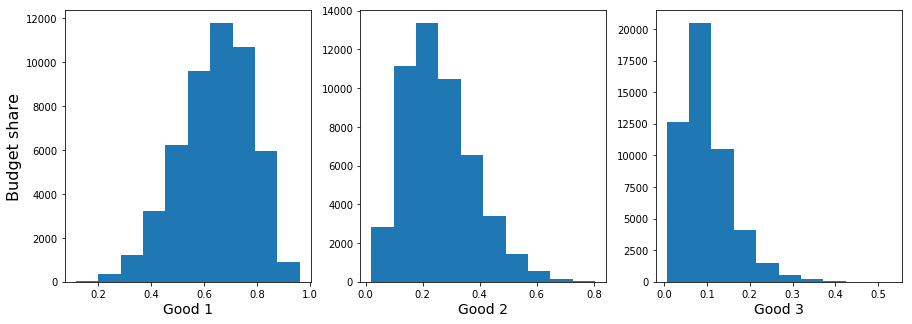

In [259]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

n, bins, patches = ax1.hist(beta_1, align='mid')
ax1.set_xlabel('Good 1', fontsize=14)
ax1.set_ylabel('Budget share', fontsize=16)


n, bins, patches = ax2.hist(beta_2, align='mid')
ax2.set_xlabel('Good 2', fontsize=14)


n, bins, patches = ax3.hist(beta_3, align='mid')
ax3.set_xlabel('Good 3', fontsize=14)

Consider the **excess demand functions:**

$$ z_i(p_1,p_2) = \sum_{j=1}^N x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j}) - e_i^j$$

**Question 2:** Plot the excess demand functions.

To plot the excess demand functions, we have to define the demand functions for each good first:

In [260]:
def dem_1(p1,e1,p2,e2,e3,beta_1):
    I = p1*e1 + p2*e2 + e3 #income, p3=1
    return beta_1*I/p1 #demand

def dem_2(p1,e1,p2,e2,e3,beta_2):
    I = p1*e1 + p2*e2 + e3 #p3=1
    return beta_2*I/p2
    
def dem_3(p1,e1,p2,e2,e3,beta_3):
    I = p1*e1 + p2*e2 + e3 #p3=1
    return beta_3*I
    
def ex_dem_1(p1, e1, p2, e2, e3):
    ag_dem_1 = np.sum(dem_1(p1,e1,p2,e2,e3,beta_1))
    ag_supply_1 = np.sum(e1)
    return ag_dem_1 - ag_supply_1

def ex_dem_2(p1,e1,p2,e2,e3):
    ag_dem_2 = np.sum(dem_2(p1,e1,p2,e2,e3,beta_2))
    ag_supply_2 = np.sum(e2)
    return ag_dem_2 - ag_supply_2

def ex_dem_3(p1,e1,p2,e2,e3):
    ag_dem_3 = np.sum(dem_1(p1,e1,p2,e2,e3,beta_3))
    ag_supply_3 = np.sum(e3)
    return ag_dem_3 - ag_supply_3

In [261]:
p1_vec = np.linspace(1,10,100)
p2_vec = np.linspace(1,10,100)

ex_dem_grid1 = np.empty((100, 100))
ex_dem_grid2 = np.empty((100, 100))


p1_grid, p2_grid = np.meshgrid(p1_vec,p2_vec,indexing='ij')

for i,p1 in enumerate(p1_vec):
    for j,p2 in enumerate(p2_vec):
        ex_dem_grid1[i,j] = ex_dem_1(p1,e1,p2,e2,e3)
        ex_dem_grid2[i,j] = ex_dem_2(p1,e1,p2,e2,e3)

Now, we can plot the excess demand functions for good 1 and 2.

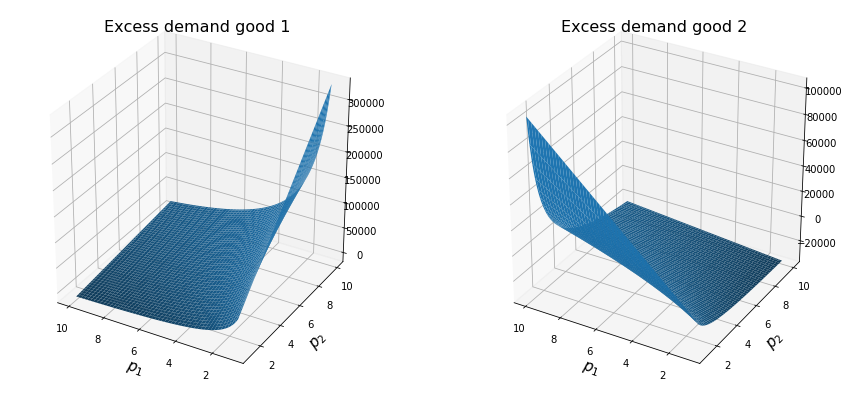

In [262]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax1.plot_surface(p1_grid, p2_grid, ex_dem_grid1)
ax1.set_xlabel('$p_1$', fontsize=15)
ax1.set_ylabel('$p_2$', fontsize=15)
ax1.set_title('Excess demand good 1', fontsize=16)
ax1.invert_xaxis()

ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.plot_surface(p1_grid, p2_grid, ex_dem_grid2)
ax2.set_xlabel('$p_1$', fontsize=15)
ax2.set_ylabel('$p_2$', fontsize=15)
ax2.set_title('Excess demand good 2', fontsize=16)
ax2.invert_xaxis()

**Question 3:** Find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, e.g. by using the following tâtonnement process:

1. Guess on $p_1 > 0$, $p_2 > 0$ and choose tolerance $\epsilon > 0$ and adjustment aggressivity parameter, $\kappa > 0$.
2. Calculate $z_1(p_1,p_2)$ and $z_2(p_1,p_2)$.
3. If $|z_1| < \epsilon$ and $|z_2| < \epsilon$ then stop.
4. Else set $p_1 = p_1 + \kappa \frac{z_1}{N}$ and $p_2 = p_2 + \kappa \frac{z_2}{N}$ and return to step 2.

In [263]:
#Guessing
pg_1 = 0.5
pg_2 = 0.5
kappa = 0.7
epsilon = 1e-8

In [264]:
# Defining the Walras-equilibrium
def walras_eq(betas,p1,e1,p2,e2,e3,kappa,epsilon,max_iter=50000):
    
    t = 0
    while True:

        # Defining z_1 and z_2
        z_1 = ex_dem_1(p1,e1,p2,e2,e3)
        z_2 = ex_dem_2(p1,e1,p2,e2,e3)
        
        # Checking whether z < epsilon
        if  (np.abs(z_1) < epsilon and np.abs(z_2) < epsilon) or t >= max_iter:
            print(f' Iteration{t:3d}: p1 ={p1:10.2f} => excess demand => {z_1:12.4f}')
            print(f' Iteration{t:3d}: p2 ={p2:10.2f} => excess demand => {z_1:12.4f}')
            break    
    
        # New p_values
        p1 = p1 + kappa*z_1/betas.size
        p2 = p2 + kappa*z_2/betas.size
            
        # Or returning 
        if t < 5 or t%400 == 0:
            print(f' Iteration{t:3d}: p1 ={p1:10.2f} => excess demand => {z_1:12.4f}')
            print(f' Iteration{t:3d}: p2 ={p2:10.2f} => excess demand => {z_2:12.4f}')
        elif t == 5:
            print(' ...')
            
        t += 1    

    return p1, p2
p1,p2 = walras_eq(betas,pg_1,e1,pg_2,e2,e3,kappa,epsilon,max_iter=50000)

 Iteration  0: p1 =      0.87 => excess demand =>   78511.7240
 Iteration  0: p2 =      0.51 => excess demand =>    1976.7759
 Iteration  1: p1 =      1.04 => excess demand =>   38106.6442
 Iteration  1: p2 =      0.56 => excess demand =>   10530.7930
 Iteration  2: p1 =      1.18 => excess demand =>   30082.1825
 Iteration  2: p2 =      0.61 => excess demand =>   10456.0117
 Iteration  3: p1 =      1.30 => excess demand =>   25718.7059
 Iteration  3: p2 =      0.65 => excess demand =>    9626.9043
 Iteration  4: p1 =      1.41 => excess demand =>   22811.3130
 Iteration  4: p2 =      0.69 => excess demand =>    8791.1017
 ...
 Iteration400: p1 =      6.03 => excess demand =>     454.7515
 Iteration400: p2 =      2.44 => excess demand =>     169.7791
 Iteration800: p1 =      6.41 => excess demand =>      73.1195
 Iteration800: p2 =      2.59 => excess demand =>      27.2811
 Iteration1200: p1 =      6.48 => excess demand =>      12.9934
 Iteration1200: p2 =      2.61 => excess demand =

The iteration shows, that the equilibrium prices are **$p_1 = 6.42$** and **$p_2 = 2.59$**

**Question 4:** Plot the distribution of utility in the Walras-equilibrium and calculate its mean and variance.

In [265]:
# Calculating the mean and variance of the utility 
def utility(betas,p1,e1,p2,e2,e3,gamma):
    
    d1 = dem_1(p1,e1,p2,e2,e3,beta_1)
    d2 = dem_2(p1,e1,p2,e2,e3,beta_2)
    d3 = dem_3(p1,e1,p2,e2,e3,beta_3)

    util_dist = np.zeros(N-1)
    for i in range(0,N-1):
        util_dist[i] = (d1[i]**betas[i,0]*d2[i]**betas[i,1]*d3[i]**betas[i,2])**gamma
        
    
    # Calculating mean and variance of utility
    utility_mean = np.mean(util_dist)
    utility_var = np.var(util_dist)
    
    # printing mean and variance
    print(f'Mean(u) = {utility_mean:.3f}')
    print(f'Var(u) = {utility_var:.3f}')
        
    return util_dist
util = utility(betas,p1,e1,p2,e2,e3,gamma)

Mean(u) = 1.010
Var(u) = 0.317


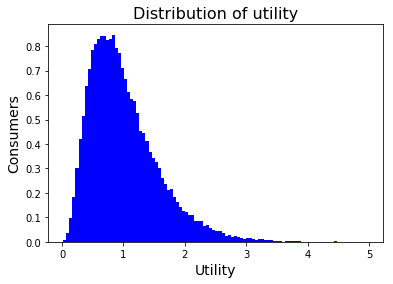

In [266]:
# Plotting the distribution of utility in the Walras-equilibrium
fig, ax = plt.subplots()
n, bins, patches = ax.hist(util, 100, density=1, facecolor='blue')
plt.title('Distribution of utility', fontsize=16)
plt.xlabel('Utility', fontsize=14)
plt.ylabel('Consumers', fontsize=14)
plt.show()

**Question 5:** Find the Walras-equilibrium prices if instead all endowments were distributed equally. Discuss the implied changes in the distribution of utility. Does the value of $\gamma$ play a role for your conclusions?

We set the endowments equal to each other, and do the same process as before.

In [267]:
equal_endow = np.random.exponential(zeta,size=N)
equal_endow = e1 = e2 = e3

p1,p2 = walras_eq(betas,pg_1,e1,pg_2,e2,e3,kappa,epsilon,max_iter=5000)

 Iteration  0: p1 =      0.87 => excess demand =>   78611.6730
 Iteration  0: p2 =      0.51 => excess demand =>    1755.9422
 Iteration  1: p1 =      1.04 => excess demand =>   38023.8400
 Iteration  1: p2 =      0.56 => excess demand =>   10507.9526
 Iteration  2: p1 =      1.18 => excess demand =>   30014.4034
 Iteration  2: p2 =      0.61 => excess demand =>   10445.1404
 Iteration  3: p1 =      1.30 => excess demand =>   25659.9482
 Iteration  3: p2 =      0.65 => excess demand =>    9613.9922
 Iteration  4: p1 =      1.41 => excess demand =>   22757.7562
 Iteration  4: p2 =      0.69 => excess demand =>    8775.8171
 ...
 Iteration400: p1 =      5.98 => excess demand =>     439.4788
 Iteration400: p2 =      2.43 => excess demand =>     164.1749
 Iteration800: p1 =      6.34 => excess demand =>      68.2504
 Iteration800: p2 =      2.56 => excess demand =>      25.4802
 Iteration1200: p1 =      6.40 => excess demand =>      11.6808
 Iteration1200: p2 =      2.58 => excess demand =

The prices are the same for the equal endowments, as in the first iteration.

In [268]:
def utility(betas,p1,e1,p2,e2,e3,gamma):
    
    d1 = dem_1(p1,e1,p2,e2,e3,beta_1)
    d2 = dem_2(p1,e1,p2,e2,e3,beta_2)
    d3 = dem_3(p1,e1,p2,e2,e3,beta_3)

    util_dist = np.zeros(N-1)
    for i in range(0,N-1):
        util_dist[i] = (d1[i]**betas[i,0]*d2[i]**betas[i,1]*d3[i]**betas[i,2])**gamma
        
    
    # Calculating mean and variance of utility
    utility_mean = np.mean(util_dist)
    utility_var = np.var(util_dist)
    
    # printing mean and variance
    print(f'Mean(u) = {utility_mean:.3f}')
    print(f'Var(u) = {utility_var:.3f}')
        
    return util_dist
util = utility(betas,p1,e1,p2,e2,e3,gamma)

Mean(u) = 0.980
Var(u) = 0.623


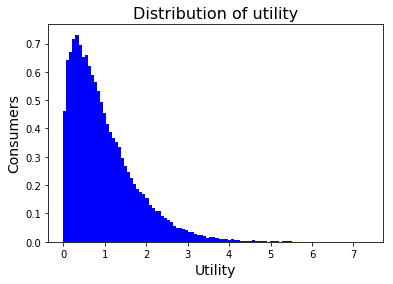

In [269]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(util, 100, density=1, facecolor='blue')
plt.title('Distribution of utility', fontsize=16)
plt.xlabel('Utility', fontsize=14)
plt.ylabel('Consumers', fontsize=14)
plt.show()

Now, with the equal endowments, the mean is lower, while the variance is higher. As it can be seen from the figure, the there is a high amount of zero values in the new distribution.

We will now show what happens to the distribution if we change $\gamma$

Mean(u) = 1.066
Var(u) = 1.138


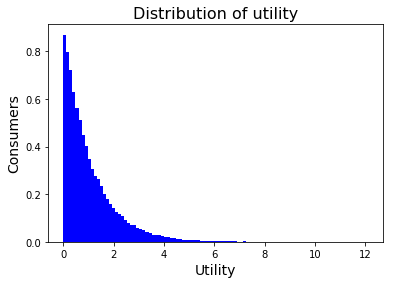

In [270]:
gamma_higher = 1

def utility(betas,p1,e1,p2,e2,e3,gamma_higher):
    
    d1 = dem_1(p1,e1,p2,e2,e3,beta_1)
    d2 = dem_2(p1,e1,p2,e2,e3,beta_2)
    d3 = dem_3(p1,e1,p2,e2,e3,beta_3)

    util_dist = np.zeros(N-1)
    for i in range(0,N-1):
        util_dist[i] = (d1[i]**betas[i,0]*d2[i]**betas[i,1]*d3[i]**betas[i,2])**gamma_higher
        
    
    # Calculating mean and variance of utility
    utility_mean = np.mean(util_dist)
    utility_var = np.var(util_dist)
    
    # printing mean and variance
    print(f'Mean(u) = {utility_mean:.3f}')
    print(f'Var(u) = {utility_var:.3f}')
        
    return util_dist
util = utility(betas,p1,e1,p2,e2,e3,gamma_higher)

fig, ax = plt.subplots()
n, bins, patches = ax.hist(util, 100, density=1, facecolor='blue')
plt.title('Distribution of utility', fontsize=16)
plt.xlabel('Utility', fontsize=14)
plt.ylabel('Consumers', fontsize=14)
plt.show()

Mean(u) = 0.958
Var(u) = 0.013


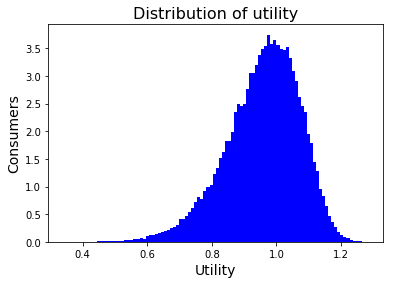

In [271]:
gamma_lower = 0.1

def utility(betas,p1,e1,p2,e2,e3,gamma_lower):
    
    d1 = dem_1(p1,e1,p2,e2,e3,beta_1)
    d2 = dem_2(p1,e1,p2,e2,e3,beta_2)
    d3 = dem_3(p1,e1,p2,e2,e3,beta_3)

    util_dist = np.zeros(N-1)
    for i in range(0,N-1):
        util_dist[i] = (d1[i]**betas[i,0]*d2[i]**betas[i,1]*d3[i]**betas[i,2])**gamma_lower
        
    
    # Calculating mean and variance of utility
    utility_mean = np.mean(util_dist)
    utility_var = np.var(util_dist)
    
    # printing mean and variance
    print(f'Mean(u) = {utility_mean:.3f}')
    print(f'Var(u) = {utility_var:.3f}')
        
    return util_dist
util = utility(betas,p1,e1,p2,e2,e3,gamma_lower)

fig, ax = plt.subplots()
n, bins, patches = ax.hist(util, 100, density=1, facecolor='blue')
plt.title('Distribution of utility', fontsize=16)
plt.xlabel('Utility', fontsize=14)
plt.ylabel('Consumers', fontsize=14)
plt.show()

So, here we can see that $\gamma$ changes the variance as we change gamma, so this would somewhat chance our conclusion. The difference seems to be in the variance, lower $\gamma$ means lower variance, the mean seem to be somewhat the same.